In [ ]:
import gdown
# https://drive.google.com/file/d/1-YNC7-LFxKXZvr9ShglAyT7rMjo84QZX/view?usp=sharing
file_id = '1-YNC7-LFxKXZvr9ShglAyT7rMjo84QZX'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'myfile.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-YNC7-LFxKXZvr9ShglAyT7rMjo84QZX
From (redirected): https://drive.google.com/uc?export=download&id=1-YNC7-LFxKXZvr9ShglAyT7rMjo84QZX&confirm=t&uuid=1812043f-fc54-4503-b6cc-bdf6554ae818
To: /content/myfile.zip
100%|██████████| 231M/231M [00:06<00:00, 35.7MB/s]


'myfile.zip'

In [ ]:
!unzip '/content/myfile.zip'

Archive:  /content/myfile.zip
  inflating: yolov3.weights          
  inflating: coco_names.txt          
  inflating: yolov3.cfg              


In [2]:
import numpy as np
import cv2 as cv
import sys

In [8]:
# 사전학습 모델(전이학습) yolo 구성
def construct_yolo3():
  f = open('./content/coco_names.txt','r')
  class_names = [ line.strip() for line in f.readlines()]
  model = cv.dnn.readNet('./content/yolov3.weights','./content/yolov3.cfg')
  layer_names = model.getLayerNames()
  output_layers = [layer_names[i-1] for i in model.getUnconnectedOutLayers()]
  return model,output_layers,class_names


In [9]:

# def yolo_detect(img,yolo_model,output_layers): # detect
# 이미의 높이(height), 폭(width)
def yolo_detect(test_img,model,out_layer,class_name):
  height, width = test_img.shape[0], img.shape[1]
  # yolo 모델에 넣기  448 x 448 모델링 되어 있으므로
  # swapRB  RGB 순서를 사
  test_img = cv.dnn.blobFromImage(test_img, 1.0/256,(448,448),(0,0,0),swapRB=True)
  # yolo모델생성

  model.setInput(test_img) # 모델에 이미지 넣기
  output3 = model.forward(out_layer) # forward
  # 박스, 신뢰도, 부류 번호
  box,conf,id = [],[],[]
  for output in output3:
    for prediction in output:
      scores = prediction[5:]  # 클래스별 신뢰도의 점수가 5부터 시
      class_id = np.argmax(scores) # 신뢰도가 가장 높은 클래스 아이디
      confidence = scores[class_id] # 신뢰도
      if confidence > 0.5: #신뢰도가 50% 이상인
        centerx, centery =  int(prediction[0]*width),int(prediction[1]*height)
        w,h = int(prediction[2]*width),int(prediction[3]*height)
        x,y = int(centerx-w/2),int(centery-h/2)
        box.append([x,y,w,h])
        conf.append(float(confidence))
        id.append(class_id)
  ind = cv.dnn.NMSBoxes(box,conf,0.5,0.4)
  object = [box[i]+[conf[i]]+[id[i]] for i in range(len(box)) if i in ind]
  return object

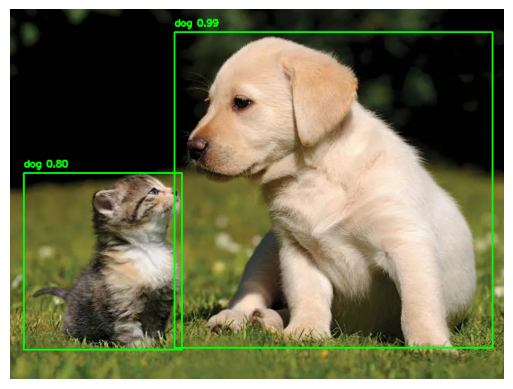

In [10]:
img = cv.imread('./content/catdog.jpg')
model,out_layer,class_name =  construct_yolo3()
object = yolo_detect(img,model,out_layer,class_name)
# 검출된 물체를 영역에 표시
for obj in object:
  x,y,w,h,conf,id = obj
  cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  text = f'{class_name[id]} {conf:.2f}'
  cv.putText(img,text,(x,y-10),cv.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)

# 이미지 표시
import matplotlib.pyplot as plt
# BGR -- RGB변경 OpenCV는 기본적으로 이미지를 BGR로 처리한다.
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
def draw_detect_result_on_video(img, obj, class_name, video_writer):
  # 검출된 물체를 영역에 표시
  for obj in obj:
    x, y, w, h, conf, id = obj
    cv.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
    text = f'{class_name[id]}{conf:.2f}'
    cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

  video_writer.write(img)

- 동영상 처리

In [17]:
import cv2 as cv
import numpy as np
# from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# YOLO 모델 로드 함수
def construct_yolo3():
    with open('./content/coco_names.txt', 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    model = cv.dnn.readNet('./content/yolov3.weights', './content/yolov3.cfg')
    layer_names = model.getLayerNames()
    output_layers = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]
    return model, output_layers, class_names

# YOLO 초기화
model, out_layer, class_names = construct_yolo3()

# 객체 감지 함수
def yolo_detect(img):
    height, width = img.shape[0], img.shape[1]
    test_img = cv.dnn.blobFromImage(img, 1.0 / 256, (416, 416), (0, 0, 0), swapRB=True)
    model.setInput(test_img)
    output3 = model.forward(out_layer)

    boxes, confidences, class_ids = [], [], []

    for output in output3:
        for prediction in output:
            scores = prediction[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:  # 신뢰도가 50% 이상인 경우
                center_x, center_y = int(prediction[0] * width), int(prediction[1] * height)
                w, h = int(prediction[2] * width), int(prediction[3] * height)
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    objects = [boxes[i] + [confidences[i]] + [class_ids[i]] for i in range(len(boxes)) if i in indices]
    return objects

# 비디오 파일 경로
video_path = './content/sample.mp4'

# 비디오 캡처 객체 생성
cap = cv.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 비디오가 끝나면 루프 종료

        # 객체 감지
        objects = yolo_detect(frame)

        # 감지된 객체에 대해 바운딩 박스 및 레이블 그리기
        for obj in objects:
            x, y, w, h, conf, id = obj
            cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = f'{class_names[id]} {conf:.2f}'
            cv.putText(frame, text, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # 프레임 표시
        clear_output(wait=True)
        cv.imshow('Frame',frame)

        # 'q' 키를 누르면 종료
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

# 비디오 캡처 객체 해제
cap.release()
cv.destroyAllWindows()

In [19]:
cap = cv.VideoCapture(0)
while True:
    ret, frame = cap.read()
    cv.imshow('webcam video', frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [4]:
from ultralytics import YOLO
import cv2
import os

# 모델 로드
model = YOLO("yolo11n.pt")

# 비디오 파일 경로
video_path = 'content/sample.mp4'

# 비디오 예측 수행 및 결과 저장
results = model(video_path, save=True, save_dir='detect_sample')

# 프레임이 저장된 디렉토리 설정
frames_dir = './detect_sample/'

# 저장할 동영상 파일 이름
video_out = 'output_video.mp4'

# 디렉토리에서 파일을 읽어와 정렬
images = [img for img in os.listdir(frames_dir) if img.endswith('.jpg')]
images.sort()

# 첫 번째 이미지로 비디오 작성 속성 설정
frame = cv2.imread(os.path.join(frames_dir, images[0]))
height, width, _ = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_out, fourcc, 30, (width, height))

# 모든 이미지를 읽어와 동영상으로 작성
for image in images:
    frame = cv2.imread(os.path.join(frames_dir, image))
    video_writer.write(frame)

# 비디오 작성 완료 후 마무리
video_writer.release()



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/199) c:\Github\python_ML\Pandas2\content\sample.mp4: 480x640 11 persons, 5 cars, 2 buss, 68.4ms
video 1/1 (frame 2/199) c:\Github\python_ML\Pandas2\content\sample.mp4: 480x640 11 persons, 2 cars, 1 bus, 62.5ms
video 1/1 (frame 3/199) c:\Github\python_ML\Pandas2\content\sample.mp4: 480x640 10 persons, 4 cars, 59.5ms
video 1/1 (frame 4/199) c:\Github\python_ML\Pandas2\content\sample.mp4: 480x640 8 persons, 3 cars, 1 truck, 60.5ms
video 1

IndexError: list index out of range